In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import requests
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.spatial import distance_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
cs = pd.read_csv('data/evictions.csv')
cs.to_parquet('data/evictions.parquet')

cs = pd.read_csv('data/parcels.csv')
cs.to_parquet('data/parcels.parquet')

/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/3003061300.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  cs = pd.read_csv('data/parcels.csv')


ValueError: Error converting column "Exemption Code" to bytes using encoding None. Original error: could not convert string to float: 'NON'

In [3]:
def load_data(url):
    response = requests.get(url)
    json_data = response.json()
    data = json_data["value"]
    df = pd.DataFrame(data)
    return df

In [4]:
def load_parcels():
    df_p = (
        pd.read_csv("data/parcels.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["the_geom"])
    ).sample(100_000)
    df_p["geometry"] = df_p["the_geom"].apply(loads)
    df_p = gpd.GeoDataFrame(df_p, geometry="geometry")
    return df_p

df_p = load_parcels()
df_p

/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/3800142517.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("data/parcels.csv")


,closed_roll_year,property_location,parcel_number,block,lot,volume_number,use_code,use_definition,property_class_code,property_class_code_definition,...,current_supervisor_districts_2,analysis_neighborhoods_2,delete_-_supervisor_districts_2,delete_-_fire_prevention_districts_2,delete_-_current_police_districts_2,delete_-_zip_codes_2,delete_-_neighborhoods_2,delete_-_police_districts_2,neighborhoods,geometry
841536,2008,0141 0139 ALHAMBRA ST0000,0466A041,0466A,41,4,MRES,Multi-Family Residential,F,Flats & Duplex,...,6.0,13.0,1.0,13.0,6.0,57.0,17.0,9.0,17.0,POINT (-122.43843 37.80188)
39744,2011,0329 0327 FULTON ST0000,0792T269A,0792T,269A,6,COMM,Commercial Misc,TS,Timeshare,...,11.0,9.0,11.0,7.0,6.0,28852.0,10.0,9.0,21.0,POINT (-122.42219 37.77861)
1025119,2009,0050 0048 TOLEDO WY0000,0466A017,0466A,17,4,MRES,Multi-Family Residential,F,Flats & Duplex,...,6.0,13.0,1.0,13.0,6.0,57.0,17.0,9.0,17.0,POINT (-122.43854 37.80146)
592696,2017,0000 0605 GENEVA AV0000,6965B045,6965B,45,41,SRES,Single Family Residential,D,Dwelling,...,1.0,28.0,6.0,9.0,4.0,28861.0,25.0,7.0,80.0,POINT (-122.44480 37.72016)
433402,2017,0000 1425 VALLEJO ST0201,572069,572,69,5,SRES,Single Family Residential,Z,Condominium,...,3.0,32.0,10.0,13.0,6.0,28858.0,32.0,9.0,105.0,POINT (-122.42085 37.79675)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266485,2016,0000 3601 LAWTON ST0000,1901001,1901,1,14,COMM,Commercial Misc,S,Gas Station,...,7.0,35.0,3.0,1.0,5.0,56.0,35.0,8.0,39.0,POINT (-122.50165 37.75662)
941082,2008,0000 0451 KANSAS ST0386,3978047,3978,47,26,SRES,Single Family Residential,Z,Condominium,...,9.0,26.0,8.0,8.0,3.0,28856.0,29.0,3.0,54.0,POINT (-122.40299 37.76411)
666705,2007,1617 1615 FULTON ST0000,1185036,1185,36,9,MRES,Multi-Family Residential,TIF,TI Flats & Duplex,...,11.0,18.0,11.0,15.0,8.0,29492.0,16.0,5.0,24.0,POINT (-122.44352 37.77594)
977337,2008,0000 2299 OCEAN AV0000,6908001,6908,1,41,SRES,Single Family Residential,D,Dwelling,...,8.0,41.0,4.0,9.0,5.0,59.0,40.0,8.0,67.0,POINT (-122.46828 37.72886)


In [5]:
def load_evictions():
    df_e = (
        pd.read_csv("data/evictions.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["shape"])
    )
    df_e["geometry"] = df_e["shape"].apply(loads)
    df_e["year"] = pd.to_datetime(df_e["file_date"]).dt.year.astype(int)
    df_e = gpd.GeoDataFrame(df_e, geometry="geometry")
    return df_e

df_e = load_evictions()
df_e

,eviction_id,address,city,state,eviction_notice_source_zipcode,file_date,non_payment,breach,nuisance,illegal_use,...,delete_-_fire_prevention_districts,delete_-_zip_codes,"cbd,_bid_and_gbd_boundaries_as_of_2017",central_market/tenderloin_boundary,"areas_of_vulnerability,_2016",central_market/tenderloin_boundary_polygon_-_updated,fix_it_zones_as_of_2018-02-07,neighborhoods,geometry,year
0,M222138,400 Block Of Eddy Street,San Francisco,CA,94102.0,12/12/22,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,POINT (-122.41508 37.78363),2022
1,M211838,900 Block Of Bush Street,San Francisco,CA,94109.0,12/6/21,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,POINT (-122.41292 37.78964),2021
2,M222033,1000 Block Of Pine Street,San Francisco,CA,94109.0,11/14/22,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,POINT (-122.41310 37.79057),2022
3,M221840,100 Block Of Caine Avenue,San Francisco,CA,94117.0,10/18/22,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,POINT (-122.45181 37.71578),2022
4,M120930,1900 Block Of Jefferson Street,San Francisco,CA,94133.0,6/21/12,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,POINT (-122.44464 37.80454),2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177573,M2K0482,2600 Block Of 36th Avenue,San Francisco,CA,94116.0,3/24/00,False,False,False,False,...,1.0,29491.0,NaN,NaN,1.0,NaN,NaN,40.0,POINT (-122.49361 37.73761),2000
177574,S000563,3500 Block Of Sacramento Street,San Francisco,CA,94118.0,10/16/97,False,False,False,False,...,11.0,54.0,NaN,NaN,1.0,NaN,NaN,10.0,POINT (-122.45113 37.78766),1997
177575,S000649,1100 Block Of Chestnut Street,San Francisco,CA,NaN,10/27/97,False,False,False,False,...,5.0,28858.0,NaN,NaN,1.0,NaN,NaN,107.0,POINT (-122.42224 37.80260),1997
177576,E991319,2100 Block Of Sacramento Street,San Francisco,CA,94115.0,7/12/99,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,POINT (-122.42828 37.79057),1999


In [6]:
def create_blocks(df_p):
    df_b = (
        df_p.loc[df_p["closed_roll_year"] == df_p["closed_roll_year"].max()]
        [["geometry", "block"]]
        .dropna()
        .drop_duplicates()
        .groupby("block")
        ["geometry"]
        .apply(lambda x: x.unary_union)
        .apply(lambda x: x.centroid)
        .reset_index()
    )
    return df_b

df_b = create_blocks(df_p)
df_b

,block,geometry
0,0026T,POINT (-122.42060 37.80547)
1,0047C,POINT (-122.42120 37.80303)
2,0071C,POINT (-122.41932 37.80169)
3,0094C,POINT (-122.41861 37.80093)
4,0095C,POINT (-122.41964 37.80037)
...,...,...
4370,995,POINT (-122.45154 37.78897)
4371,996,POINT (-122.45003 37.78921)
4372,997,POINT (-122.44819 37.78936)
4373,998,POINT (-122.44648 37.78958)


In [7]:
def merge_blocks_parcels(df_p, df_b):
    # Merge blocks onto parcels
    df = (
        df_p.merge(df_b, on="block", how="left")
        .rename(columns={"geometry_x": "geometry"})
        .dropna(subset=["geometry"])
    )
    df = gpd.GeoDataFrame(df, geometry="geometry")
    df = gpd.sjoin_nearest(df, df_b, how="left", max_distance=0.01)
    df["current_sales_date"] = (
        pd.to_datetime(df["current_sales_date"])
        .dt.year
        .fillna(-1)
        .astype(int)
    )
    # df["year_property_built"] = df["year_property_built"].fillna(-1).astype(int)
    return df

def aggregate_parcels(df):
    # Aggregate parcels by block and year
    mode = lambda x: x.value_counts().index[0]
    def by_year(df_y):
        return df_y.groupby("block_right").agg({
            "assessed_personal_property_value": "mean",
            "assessed_land_value": "mean",
            "assessed_fixtures_value": "mean",
            "assessed_improvement_value": "mean",
            "property_area": "mean",
            "number_of_units": "sum",
            "number_of_rooms": "mean",
            "number_of_bedrooms": "mean",
            "number_of_bathrooms": "mean",
            # "zoning_code": mode,
            # "property_class_code": mode,
        })
    df = (
        df.groupby("closed_roll_year")
        .apply(by_year)
        .reset_index()
        .rename(columns={"block_right": "block", "closed_roll_year": "year"})
    )
    return df

def merge_evictions_blocks(df_e, df_b, df):
    # Merge evictions onto blocks
    df_e = gpd.sjoin_nearest(df_e, df_b, how="left", max_distance=0.001)
    df_e_agg = (
        df_e.groupby(["block", "year"])
        .size()
        .reset_index()
        .rename(columns={0: "eviction_count"})
    )
    def by_year(df_y):
        df_e_year = df_e_agg.loc[df_e_agg["year"] == df_y["year"].max()]
        return df_y.merge(df_e_year, how="left", on=["block"])
    df = df.groupby("year").apply(by_year).reset_index()
    df["eviction_count"] = df["eviction_count"].fillna(0).astype(int)
    df = df.drop(columns=["level_1", "year_x", "year_y"])
    return df

df = merge_blocks_parcels(df_p, df_b)
df = aggregate_parcels(df)
df = merge_evictions_blocks(df_e, df_b, df)
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,number_of_bathrooms,eviction_count
0,2007,0026T,0.000000,4.054008e+03,0.0,6.720015e+03,28.546154,99,0.115385,0.046154,0.023077,0
1,2007,0047C,0.000000,3.884217e+05,0.0,8.129670e+05,862.500000,3,2.833333,0.000000,1.166667,0
2,2007,0071C,0.000000,6.444264e+05,0.0,1.135658e+06,204.714286,1,0.714286,0.285714,0.285714,0
3,2007,0094C,0.000000,3.865566e+05,0.0,5.246991e+05,448.285714,1,1.285714,0.000000,0.285714,0
4,2007,0095C,0.000000,5.383334e+05,0.0,1.903347e+06,7390.400000,20,24.200000,13.600000,4.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21458,2017,995,0.000000,1.461578e+06,0.0,1.213401e+06,3170.250000,4,8.000000,4.000000,3.000000,0
21459,2017,996,0.000000,2.010323e+06,0.0,1.534258e+06,2820.000000,3,8.333333,2.333333,2.000000,0
21460,2017,997,0.000000,2.863336e+06,0.0,1.659826e+06,4629.500000,9,14.750000,5.000000,4.250000,0
21461,2017,998,474.857143,9.165180e+05,0.0,7.139713e+05,4355.857143,19,15.142857,1.000000,3.571429,0


In [8]:
def build_graph(df_b):
    graph = nx.Graph()
    graph.add_nodes_from(df_b["block"])
    
    coordinates = [list(p.coords)[0] for p in df_b["geometry"]]
    matrix = distance_matrix(coordinates, coordinates)
    max_d = matrix.max()
    p = 0.025
    neighbors = np.argwhere(matrix < max_d*p)
    for i, j in tqdm(neighbors, total=len(neighbors)):
        if i < j:
            graph.add_edge(
                df_b.iloc[i]["block"], 
                df_b.iloc[j]["block"], 
                weight=matrix[i, j]
            )
    return graph

graph = build_graph(df_b)

100%|██████████| 107851/107851 [00:05<00:00, 18439.55it/s]


In [9]:
pd.Series([graph.degree(n) for n in graph.nodes]).describe()

count    4375.000000
mean       23.651657
std         7.595289
min         0.000000
25%        19.000000
50%        24.000000
75%        28.000000
max        62.000000
dtype: float64

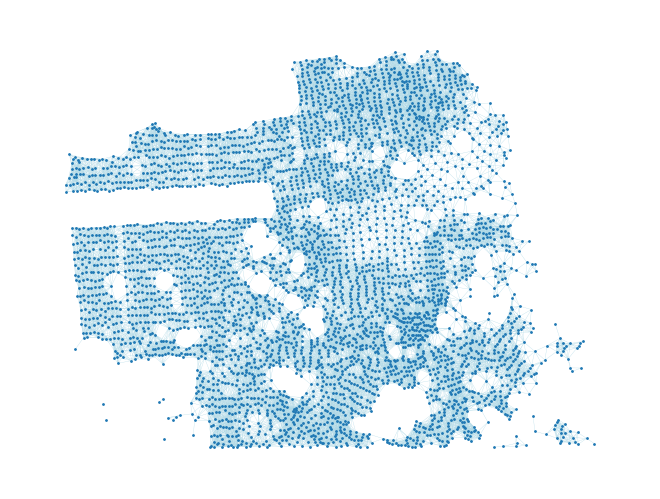

In [10]:
nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=1, width=0.2)

In [11]:
def compute_features():
    # Compute basic spatial features for each parcel
    
    pass

In [12]:
# example degree cacluation, group by year then calculate degree

def degree_calc():
    def by_year(df_y):
        df_y["degree"] = df_y["block"].apply(lambda x: graph.degree(x))
        return df_y
    

    return (df.groupby("year").apply(by_year))

dfTemp = degree_calc()
print(dfTemp["degree"])
print(dfTemp["degree"].describe())

0        22
1        33
2        37
3        40
4        38
         ..
21458    25
21459    24
21460    24
21461    25
21462    27
Name: degree, Length: 21463, dtype: int64
count    21463.000000
mean        23.976704
std          7.454601
min          0.000000
25%         20.000000
50%         24.000000
75%         28.000000
max         62.000000
Name: degree, dtype: float64


/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/68344156.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return (df.groupby("year").apply(by_year))


In [13]:
# average assessed land value for propery, group by year, group by block, iterate through property per block then calculate average
def value_calc(property_name):
    def by_year(df_y):
        df_y[f"avg_{property_name}"] = df_y.groupby("block")[property_name].transform("mean")
        return df_y

    return df.groupby("year").apply(by_year)


df_temp = value_calc("assessed_land_value")
print(df_temp["avg_assessed_land_value"])
print(df_temp["avg_assessed_land_value"].describe())


0        4.054008e+03
1        3.884217e+05
2        6.444264e+05
3        3.865566e+05
4        5.383334e+05
             ...     
21458    1.461578e+06
21459    2.010323e+06
21460    2.863336e+06
21461    9.165180e+05
21462    1.953757e+06
Name: avg_assessed_land_value, Length: 21463, dtype: float64
count    2.146300e+04
mean     5.470833e+05
std      3.134876e+06
min      0.000000e+00
25%      1.460157e+05
50%      2.518235e+05
75%      4.187199e+05
max      1.895997e+08
Name: avg_assessed_land_value, dtype: float64


/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/2639719963.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("year").apply(by_year)


[0.00000000e+00 1.46015667e+05 2.51823500e+05 4.18719875e+05
 1.89599684e+08]
      block                     geometry land_value_quartiles
0     0026T  POINT (-122.42060 37.80547)                   Q1
1     0047C  POINT (-122.42120 37.80303)                   Q3
2     0071C  POINT (-122.41932 37.80169)                   Q4
3     0094C  POINT (-122.41861 37.80093)                   Q3
4     0095C  POINT (-122.41964 37.80037)                   Q4
...     ...                          ...                  ...
4370    995  POINT (-122.45154 37.78897)                   Q1
4371    996  POINT (-122.45003 37.78921)                   Q3
4372    997  POINT (-122.44819 37.78936)                   Q2
4373    998  POINT (-122.44648 37.78958)                   Q1
4374    999  POINT (-122.44500 37.78961)                   Q1

[4375 rows x 3 columns]


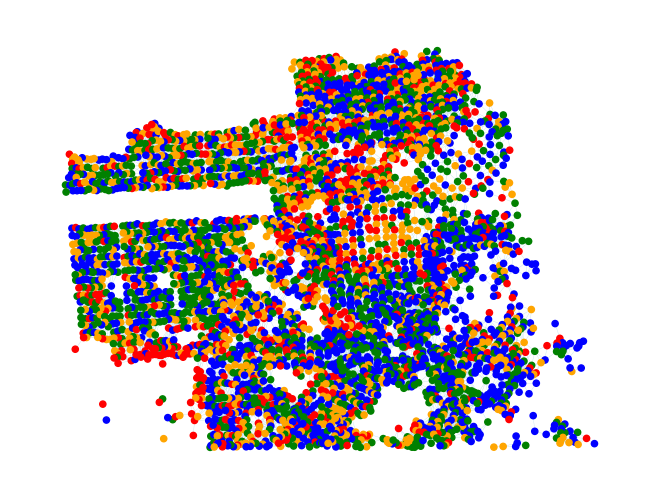

In [14]:
# Split land value into quartiles, and map based on ranges
df_b["land_value_quartiles"], bins = pd.qcut(df_temp["assessed_land_value"], q=4, labels=["Q1", "Q2", "Q3", "Q4"], retbins=True)

print(bins)
print(df_b)

colors = {"Q1": "blue", "Q2": "green", "Q3": "orange", "Q4": "red"}

node_colors = [colors[q] for q in df_b.set_index("block")["land_value_quartiles"]]

nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=20, width=0.2, node_color=node_colors)


In [15]:
print(df.columns)

# Average improvement value for property, group by year, group by block, iterate through property per block then calculate average

def value_calc(property_name):
    def by_year(df_y):
        df_y[f"avg_{property_name}"] = df_y.groupby("block")[property_name].transform("mean")
        return df_y

    return df.groupby("year").apply(by_year)


df_temp = value_calc("assessed_improvement_value")
print(df_temp["avg_assessed_improvement_value"])
print(df_temp["avg_assessed_improvement_value"].describe())

Index(['year', 'block', 'assessed_personal_property_value',
       'assessed_land_value', 'assessed_fixtures_value',
       'assessed_improvement_value', 'property_area', 'number_of_units',
       'number_of_rooms', 'number_of_bedrooms', 'number_of_bathrooms',
       'eviction_count'],
      dtype='object')
0        6.720015e+03
1        8.129670e+05
2        1.135658e+06
3        5.246991e+05
4        1.903347e+06
             ...     
21458    1.213401e+06
21459    1.534258e+06
21460    1.659826e+06
21461    7.139713e+05
21462    1.258662e+06
Name: avg_assessed_improvement_value, Length: 21463, dtype: float64
count    2.146300e+04
mean     6.101184e+05
std      5.174533e+06
min      0.000000e+00
25%      1.322268e+05
50%      2.090897e+05
75%      3.488192e+05
max      3.534633e+08
Name: avg_assessed_improvement_value, dtype: float64


/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/1269474137.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("year").apply(by_year)


[  0.   2.   4.   8. 720.]


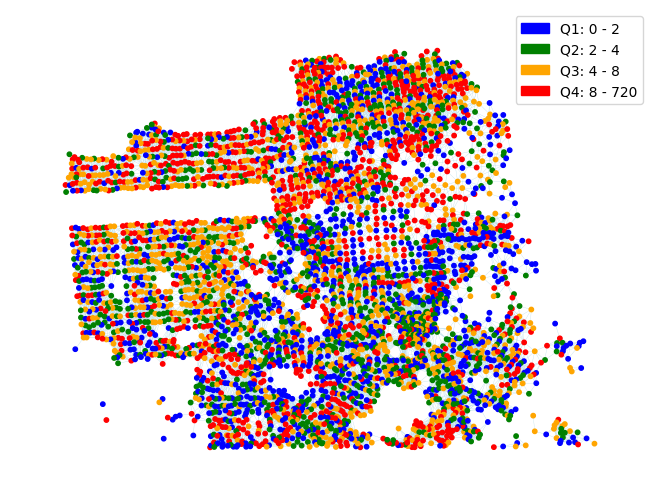

In [16]:
# Group by number of units, split into quartiles, map based on splits

df_b["unit_number_quartiles"], bins = pd.qcut(df_temp["number_of_units"], q=4, labels=["Q1", "Q2", "Q3", "Q4"], retbins=True)

print(bins)
# print(df_b)

colors = {"Q1": "blue", "Q2": "green", "Q3": "orange", "Q4": "red"}

node_colors = [colors[q] for q in df_b.set_index("block")["unit_number_quartiles"]]

nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=10, width=0.2, node_color=node_colors)

# make legend for colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Q1: 0 - ' + str(int(bins[1])))
green_patch = mpatches.Patch(color='green', label='Q2: ' + str(int(bins[1])) + ' - ' + str(int(bins[2])))
orange_patch = mpatches.Patch(color='orange', label='Q3: ' + str(int(bins[2])) + ' - ' + str(int(bins[3])))
red_patch = mpatches.Patch(color='red', label='Q4: ' + str(int(bins[3])) + ' - ' + str(int(bins[4])))



plt.legend(handles=[blue_patch, green_patch, orange_patch, red_patch])



/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_64078/1301544912.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


AxesSubplot(0.125,0.11;0.62x0.77)


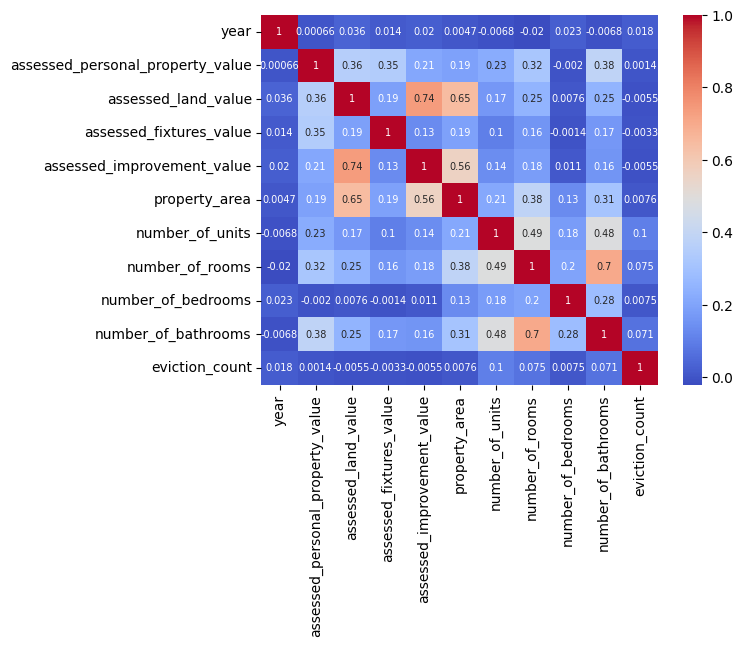

In [17]:
# plot the relationship between land value and improvement value
import seaborn as sb

corr = df.corr()
corr = sb.heatmap(corr, annot=True, annot_kws={"size": 7}, cmap='coolwarm')

print(corr)



count    2.146300e+04
mean    -6.303515e+04
std      3.561045e+06
min     -2.960205e+08
25%     -1.618200e+04
50%      3.155722e+04
75%      1.036848e+05
max      6.319989e+07
dtype: float64
[  0.   2.   4.   8. 720.]


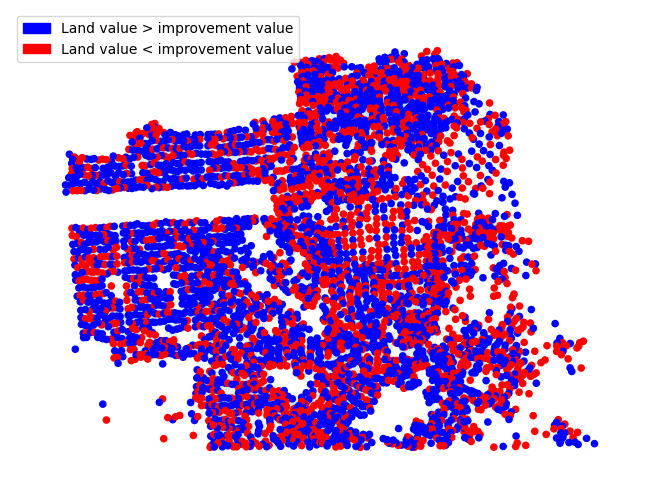

In [20]:
import random

# graph based on if land value is greater than improvement value, group by year and calculate by block

arr = df_temp["assessed_land_value"] - df_temp["assessed_improvement_value"]
print(arr.describe())

df_b["land_value_difference"] = arr > 0
print(bins)

colors = {True: "blue", False: "red"}

node_colors = [colors[q] for q in df_b.set_index("block")["land_value_difference"]]

nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=20, width=0.2, node_color=node_colors)

# make legend for colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Land value > improvement value')
red_patch = mpatches.Patch(color='red', label='Land value < improvement value')

plt.legend(handles=[blue_patch, red_patch])
plt.show()

count    2.146300e+04
mean    -6.303515e+04
std      3.561045e+06
min     -2.960205e+08
25%     -1.618200e+04
50%      3.155722e+04
75%      1.036848e+05
max      6.319989e+07
Name: value_improvement_difference, dtype: float64
Index(['year', 'block', 'assessed_personal_property_value',
       'assessed_land_value', 'assessed_fixtures_value',
       'assessed_improvement_value', 'property_area', 'number_of_units',
       'number_of_rooms', 'number_of_bedrooms', 'number_of_bathrooms',
       'eviction_count', 'avg_assessed_improvement_value',
       'value_improvement_difference'],
      dtype='object')


Index(['closed_roll_year', 'property_location', 'parcel_number', 'block',
       'lot', 'volume_number', 'use_code', 'use_definition',
       'property_class_code', 'property_class_code_definition',
       'year_property_built', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_of_stories', 'number_of_units',
       'zoning_code', 'construction_type', 'lot_depth', 'lot_frontage',
       'property_area', 'basement_area', 'lot_area', 'lot_code',
       'tax_rate_area_code', 'percent_of_ownership', 'exemption_code',
       'exemption_code_definition', 'status_code', 'misc_exemption_value',
       'homeowner_exemption_value', 'current_sales_date',
       'assessed_fixtures_value', 'assessed_improvement_value',
       'assessed_land_value', 'assessed_personal_property_value',
       'assessor_neighborhood_district', 'assessor_neighborhood_code',
       'assessor_neighborhood', 'supervisor_district', 'analysis_neighborhood',
       'the_geom', 'row_id', 'sf_find_

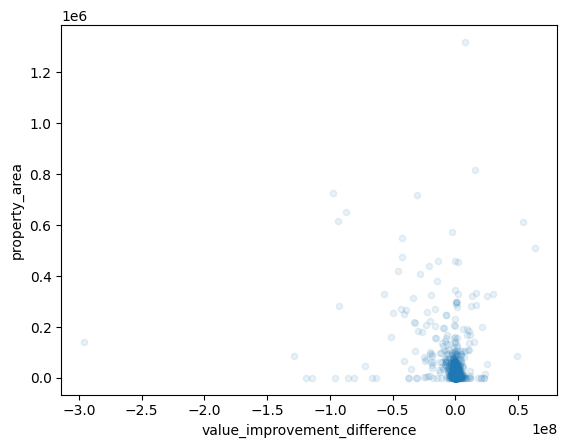

In [19]:
df_temp["value_improvement_difference"] = df_temp["assessed_land_value"] - df_temp["assessed_improvement_value"]
print(df_temp["value_improvement_difference"].describe())
print(df_temp.columns)

df_temp.plot(x="value_improvement_difference",y="property_area", kind="scatter", alpha=0.1)
df_p.columns
